In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import utm

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score, mean_squared_error, classification_report

import tensorflow as tf
import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, TimeDistributed, Input, Activation, concatenate
from keras.callbacks import History
from keras.models import Model

# The values have around 15 decimals, so for more clarity in reading we're increasing the number of displayed values
pd.set_option('display.float_format', '{:.15f}'.format)

# 1. Importing the data

In [2]:
sensor_and_loc_file = '../data/Processed/full_sensor_data_and_location.csv'

In [3]:
df_sensor_and_loc = pd.read_csv(sensor_and_loc_file, index_col=0)
df_sensor_and_loc

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
12:15:51:60,0.558120700000000,0.496215820000000,9.361587999999999,0.074188230000000,0.290191650000000,-0.387237550000000,52.349854000000001,-50.549315999999997,-260.850520000000017,9.391328912221676,0.489558992696751,270.811252251747476,44.434937499999997,26.047601499999999
12:15:51:61,0.412078860000000,0.443542480000000,9.409470000000001,0.032653810000000,0.321075440000000,-0.377655030000000,52.368546000000002,-50.530624000000003,-260.906787500000007,9.428927012090160,0.496768589146909,270.865587926351282,44.434937499999990,26.047601578717067
12:15:51:62,0.378555300000000,0.465087900000000,9.435805999999999,0.018798828000000,0.324279800000000,-0.366989140000000,52.387238000000004,-50.511932000000002,-260.963054999999997,9.454842449217251,0.490093678290338,270.919923600955030,44.434937499999990,26.047601657434136
12:15:51:63,0.468096920000000,0.524942020000000,9.467889200000000,0.034353637600000,0.316397106000000,-0.364859012000000,52.405929999999998,-50.493240000000000,-261.019322499999987,9.496275903028236,0.485338498843436,270.974259275558779,44.434937499999982,26.047601736151204
12:15:51:64,0.557638540000000,0.584796140000000,9.499972400000001,0.049908447200000,0.308514412000000,-0.362728884000000,52.424621999999999,-50.474547999999999,-261.075590000000034,9.537709356839221,0.480583319396533,271.028594950162585,44.434937499999982,26.047601814868269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19:09:27:16,1.302719100000000,0.520156860000000,7.142166000000000,-0.118621826000000,-0.505569460000000,0.092132570000000,22.650145999999999,-15.150451500000001,-262.875364999999988,7.278610814164050,0.527408785424618,264.286459212824525,44.434937499964583,26.047601919741037
19:09:27:17,2.049713100000000,0.280731200000000,8.202788999999999,-0.301849370000000,-0.332992550000000,0.140075680000000,23.100280000000001,-16.200256000000000,-262.800599999999974,8.459662001373697,0.470763503951147,264.310852200404213,44.434937499964576,26.047601814784940
19:09:27:18,2.140686000000000,0.043701172000000,9.170044000000001,-0.590530400000000,0.304031370000000,0.046325684000000,23.100280000000001,-13.949585000000001,-261.749270000000024,9.416695455676912,0.665813259304968,263.136645496752351,44.434937499964576,26.047601709828850
19:09:27:19,1.896484400000000,-0.226837160000000,9.799728000000000,-0.686401370000000,0.651306150000000,-0.067657470000000,24.050394333333333,-13.749694999999999,-262.549340000000029,9.984126253738191,0.948643281224560,264.009983987171552,44.434937499964569,26.047601604872760


In [4]:
data = df_sensor_and_loc.copy(deep=True)[::10]

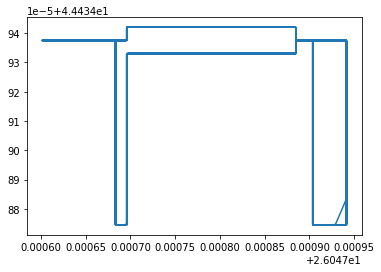

In [5]:
plt.plot(data['long'], data['lat'])

# 2. Creating the LSTM model

## 2.1. Scaling the data

In [ ]:
backcandles=100

sc_attributes = MinMaxScaler(feature_range=(-1, 1))
attributes_scaled = sc_attributes.fit_transform(data.iloc[:, :-5])
sc_targets = MinMaxScaler(feature_range=(0, 1))
targets_scaled = sc_targets.fit_transform(data.iloc[backcandles:, [-2, -1]])